# Across-Subject Analyses
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4500/7559 --- Fall 2020
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. How to read in all the data
2. Perform some simple data clean-up
3. Some more Pandas analysis tricks
4. Regression across subjects


# Updating SMILE

- First you can test whether there is a new version Kivy, which is the primary dependency of SMILE:

```bash
conda install -c conda-forge kivy==1.11.1
```

- Then you can update SMILE right from the GitHub repository (note the upgrade option at the end):

```bash
pip install git+https://github.com/compmem/smile --upgrade
```

# Loading in all the data

- Let's explore one subject's data and learn stuff along the way!
- Where are the data?

In [128]:
ls data/Taskapalooza/s001

log_flanker_0.slog        state_If_0.slog
log_image_study_0.slog    state_Image_0.slog
log_image_test_0.slog     state_KeyPress_0.slog
log_math_distract_0.slog  state_Label_0.slog
log_math_distract_1.slog  state_Loop_0.slog
log_word_study_0.slog     state_Parallel_0.slog
log_word_test_0.slog      state_ParentSet_0.slog
state_Beep_0.slog         state_Rectangle_0.slog
state_Button_0.slog       state_Serial_0.slog
state_ButtonPress_0.slog  state_SubroutineState_0.slog
state_Elif_0.slog         state_Wait_0.slog
state_Func_0.slog         sysinfo.slog


In [2]:
from smile.log import log2dl
import numpy as np
from scipy import stats
import pandas as pd
from glob import glob
import os


## Glob?

- Allows for pattern matching for files
- Here we want to return a list of all the subject directories matching a specific pattern

In [131]:
glob('data/Taskapalooza/s???')

['data/Taskapalooza/s018',
 'data/Taskapalooza/s006',
 'data/Taskapalooza/s013',
 'data/Taskapalooza/s015',
 'data/Taskapalooza/s014',
 'data/Taskapalooza/s001',
 'data/Taskapalooza/s003',
 'data/Taskapalooza/s008',
 'data/Taskapalooza/s005',
 'data/Taskapalooza/s016',
 'data/Taskapalooza/s002',
 'data/Taskapalooza/s021',
 'data/Taskapalooza/s017',
 'data/Taskapalooza/s011',
 'data/Taskapalooza/s022',
 'data/Taskapalooza/s007',
 'data/Taskapalooza/s010',
 'data/Taskapalooza/s019',
 'data/Taskapalooza/s020',
 'data/Taskapalooza/s023',
 'data/Taskapalooza/s009',
 'data/Taskapalooza/s012',
 'data/Taskapalooza/s004']

## Manipulating paths with `os.path`

- Different operation systems have different ways of dealing with directories
  - Windows separate directories with `\`
  - Most others use `/`
- Python can handle processing paths for you with the `os.path` module

In [4]:
# split up the path
os.path.split('data/Taskapalooza/s018')

('data/Taskapalooza', 's018')

## Custom SLOG loading function

In [5]:
# custom function to load slogs
def load_all_subj_logs(task_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.split(subj_dir)[-1] 
             for subj_dir in glob(os.path.join(task_dir, 's*'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(task_dir, subj, log_file)
        #print(log_path)

        # load the data
        all_dat.extend(log2dl(log_path, subj=subj))

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [6]:
# load the data from each task
task_dir = os.path.join('data', 'Taskapalooza')

df_f = load_all_subj_logs(task_dir, 'log_flanker')
df_m = load_all_subj_logs(task_dir, 'log_math_distract')
df_i = load_all_subj_logs(task_dir, 'log_image_test')
df_w = load_all_subj_logs(task_dir, 'log_word_test')
df_f.head()

,resp_map_left,resp_map_right,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,correct,location_0,location_1,log_time,condition,direction,stimulus,subj,log_num
0,F,J,0,0,1829.983096,0.0,F,1830.614606,0.000206,0.631509,True,1124.413938,852.384884,1831.313423,neutral,left,===<===,s001,0
1,F,J,0,1,1831.320258,0.0,J,1831.708334,0.000181,0.388076,True,1488.898432,948.599964,1832.235087,neutral,right,===>===,s001,0
2,F,J,0,2,1832.244198,0.0,F,1832.818232,0.000197,0.574034,True,1853.572485,748.901092,1833.391370,neutral,left,===<===,s001,0
3,F,J,0,3,1833.404586,0.0,F,1833.990549,0.000203,0.585963,True,1413.608109,996.704422,1834.859940,neutral,left,===<===,s001,0
4,F,J,0,4,1834.876087,0.0,F,1835.262948,0.000186,0.386861,True,1557.565574,686.474531,1836.017047,neutral,left,===<===,s001,0


## Some data clean-up

In [132]:
# it turns out the cond is easier to visualize as pure and mixed
def fix_conds(df, type_col):
    # loop over the unique subjects
    usubj = df.subj.unique()
    for s in usubj:
        # loop over their blocks
        ublocks = df.loc[df['subj']==s, 'block_num'].unique()
        for b in ublocks:
            # grab the data for that subj and block
            dfb = df.loc[(df['subj']==s)&(df['block_num']==b)]
            
            # get the unique types in that block
            uval = dfb[type_col].unique()
            if len(uval) > 1:
                # it's mixed
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'mixed'
            else:
                # it's the pure
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'pure'

# fix the conds in the recog experiments (updated in place)
fix_conds(df_i, type_col='in_out')
fix_conds(df_w, type_col='valence')


# add in log_rt columns
df_i['log_rt'] = np.log(df_i['rt'])
df_w['log_rt'] = np.log(df_w['rt'])
df_f['log_rt'] = np.log(df_f['rt'])
df_m['log_rt'] = np.log(df_m['rt'])

## Check Math Performance

- We want to calculate mean performance and run a binomial test on each participant
- How can we do this efficiently with Pandas?

## Start with a `groupby`

- We know we can group rows of data by subject and apply a function to specific columns

In [137]:
df_m.groupby(['subj']).groups['s011']

Int64Index([ 922,  923,  924,  925,  926,  927,  928,  929,  930,  931,
            ...
            1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031],
           dtype='int64', length=110)

In [8]:
df_m.groupby(['subj'])['correct'].mean()

subj
s001    0.797753
s002    0.767677
s003    0.977528
s004    0.875000
s005    0.862745
s006    0.934783
s007    0.913043
s008    0.768421
s009    0.892857
s010    0.793478
s011    0.881818
s012    0.942857
s013    0.858696
s014    0.804124
s015    0.723404
s016    0.881720
s017    0.814433
s018    0.989247
s019    0.858974
s020    0.955056
s021    0.967391
s022    0.847619
s023    0.700000
Name: correct, dtype: float64

## The `agg` method can help

- `agg` allows us to run more than one function on each group
- Can provide either a string or the actual function
- We need the `sum` and the `count` for the binomial test

In [9]:
mperf = df_m.groupby(['subj'])['correct'].agg(['sum', 'count', 'mean'])
mperf.head()

,sum,count,mean
subj,,,
s001,71,89,0.797753
s002,76,99,0.767677
s003,87,89,0.977528
s004,77,88,0.875000
s005,88,102,0.862745


## Use `apply` to run a function on each row

- The `apply` method of a `DataFrame` allows you to 
- Here we need to specify a custom function that uses the info from each row to call `stats.binom_test`
  - We could have defined a separate function
  - But here I'll use `lambda` to define a function inline, since it's only one line of code

In [ ]:
def run_binom_test(x):
    return stats.binom_test(x['sum'], n=x['count'], 
                             p=0.5, alternative='greater'),

In [145]:
# add the binom_test p value as a new column (axis=1 tells it to go by row)
mperf['binom_pval'] = mperf.apply(lambda x: stats.binom_test(x['sum'], n=x['count'], 
                                                             p=0.5, alternative='greater'),
                                  axis=1)

# they are good if the mean is greater than 0.5 and the pval is less that .05
mperf['good'] = (mperf['mean']>0.5) & (mperf['binom_pval'] <= 0.05)
mperf

,sum,count,mean,binom_pval,good
subj,,,,,
s001,71,89,0.797753,6.484375e-09,True
s002,76,99,0.767677,4.267164e-08,True
s003,87,89,0.977528,6.472042e-24,True
s004,77,88,0.875000,1.200777e-13,True
s005,88,102,0.862745,1.387694e-14,True
s006,86,92,0.934783,1.545247e-19,True
s007,84,92,0.913043,2.072124e-17,True
s008,73,95,0.768421,7.314912e-08,True
s009,75,84,0.892857,2.154292e-14,True


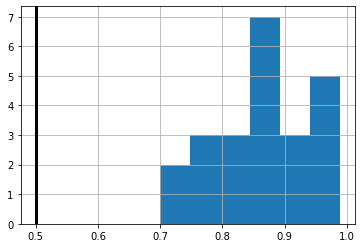

In [148]:
# quick plot of performance
ax = mperf['mean'].hist(bins='auto')
ax.axvline(0.5, color='k', lw=3)

<AxesSubplot:xlabel='subj'>

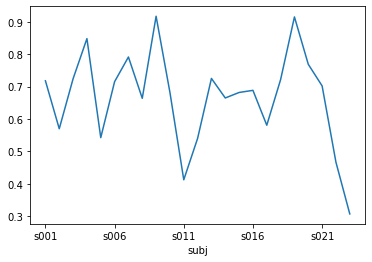

In [152]:
df_m.groupby(['subj'])['log_rt'].mean().plot()

<AxesSubplot:title={'center':'log_rt'}, xlabel='[subj]'>

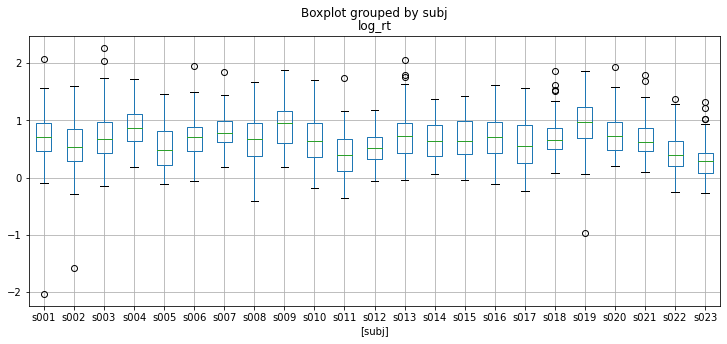

In [154]:
df_m.boxplot(column=['log_rt'], by=['subj'], figsize=(12,5))

## What about performance on the easy flanker conditions?

- Another way to test for task compliance is to check the performance on the easiest task conditions.
- ***Question: Did the participant perform above chance on the congruent flanker trials?***

In [155]:
stats.binom_test?

In [156]:
fperf = df_f.groupby(['subj', 'condition'])['correct'].agg(['sum', 'count', 'mean'])
fperf['binom_pval'] = fperf.apply(lambda x: stats.binom_test(x['sum'], n=x['count'], 
                                                             p=0.5, alternative='two-sided'),
                                  axis=1)
fperf

sum  count      mean    binom_pval
subj condition                                      
s001 congruent     94     96  0.979167  1.175592e-25
     incongruent   80     96  0.833333  2.074411e-11
     neutral       95     96  0.989583  2.448624e-27
s002 congruent     94     96  0.979167  1.175592e-25
     incongruent   91     96  0.947917  1.630571e-21
...               ...    ...       ...           ...
s022 incongruent   89     96  0.927083  3.259153e-19
     neutral       95     96  0.989583  2.448624e-27
s023 congruent     92     96  0.958333  8.758242e-23
     incongruent   36     96  0.375000  1.843335e-02
     neutral       90     96  0.937500  2.503256e-20

[69 rows x 4 columns]

## Congruency effect

- The typical congruency effect is that participants show lower accuracy and slower reaction times in the incongruent relative to the congruent conditions
- Let's check that for all our participants!

### Performance by condition

Text(0.5, 0, 'Condition')

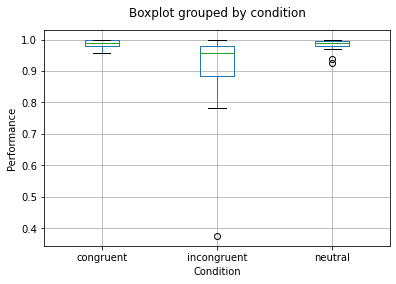

In [15]:
# Let's make a boxplot of the performance values
ax = fperf.boxplot(column='mean', by=['condition'])
ax.set_title('')
ax.set_ylabel('Performance')
ax.set_xlabel('Condition')

### RT by condition

Text(0.5, 0, 'Condition')

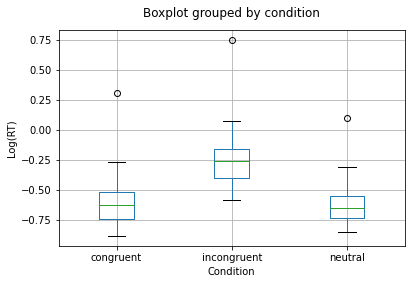

In [16]:
fres = df_f.groupby(['subj', 'condition'])['log_rt'].mean().reset_index()
ax = fres.boxplot(column='log_rt', by=['condition'])
ax.set_title('')
ax.set_ylabel('Log(RT)')
ax.set_xlabel('Condition')

## Error bars for repeated measures designs

- The box plots above do not actually show us the relationships between the conditions that indicate significance
- We have a repeated-measures design, with different conditions *within* subjects
- Thus, the real comparisons of interest are *within* subjects, not *between* subjects
  - In the box plots, the between-subject variability is masking the within-subject effects!
- To help us visualize the differences more-accurately, we can calculate within-subject corrected error bars
  - All this entails is removing the within-subject mean across conditions before calculating error

In [17]:
# some folks wrote a useful script for calculating these for us!
from ci_within import ci_within

In [61]:
# get the error corrected by condition and whether they got it correct
res = ci_within(df_f, indexvar='subj', 
                withinvars=['condition', 'correct'], 
                measvar='log_rt')
res

mean       std       sem        ci     len
condition   correct                                                
congruent   False   -0.649545  0.295123  0.061537  0.127621    23.0
            True    -0.593183  0.257711  0.005513  0.010812  2185.0
incongruent False   -0.581388  0.427261  0.029914  0.058983   204.0
            True    -0.211566  0.329754  0.007366  0.014446  2004.0
neutral     False   -0.591497  0.518851  0.086475  0.175554    36.0
            True    -0.614623  0.225998  0.004849  0.009510  2172.0

## Unstacking and Resetting Index

- After a group-by, we often need to pivot the data so that it has the right indices for plotting
- The `unstack` command takes a multi-level index and moves one of the row indices to a column
- Here we'll move the `correct` row indicator to be a column indicator
- Calling `reset_index` will fill in the values in all the index columns and add in an overall index.

In [158]:
# must unstack and reset index to plot properly
res.unstack().reset_index()

condition      mean                 std                 sem  \
correct                  False      True     False      True     False   
0          congruent -0.649545 -0.593183  0.295123  0.257711  0.061537   
1        incongruent -0.581388 -0.211566  0.427261  0.329754  0.029914   
2            neutral -0.591497 -0.614623  0.518851  0.225998  0.086475   

                         ci              len          
correct      True     False      True  False    True  
0        0.005513  0.127621  0.010812   23.0  2185.0  
1        0.007366  0.058983  0.014446  204.0  2004.0  
2        0.004849  0.175554  0.009510   36.0  2172.0

Text(0, 0.5, 'Log(RT)')

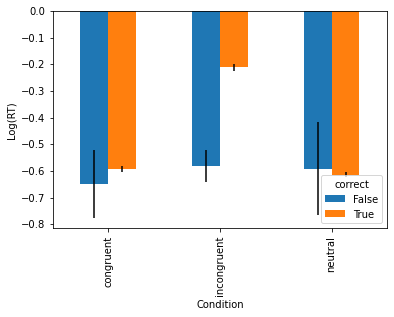

In [114]:
# plot the results
ax = res.unstack().reset_index().plot(x='condition', y='mean', yerr='ci', kind="bar")
#ax.get_legend().remove()
ax.set_xlabel('Condition')
ax.set_ylabel('Log(RT)')

## Regression and beyond!

- This sure looks significant, but we need to build a regression to test all these factors

![](https://scipy-lectures.org/_images/math/8c27948834377cd91a6907f91d1f87acb32f1817.png)

- Here `y` is the dependent variable and `x` is the independent variable(s).
- This is also often called *endogenous* and *exogenous*.

## Statsmodels allows us to specify regressions as formulas

- There are many ways to fit regression models that often depend on your dependent data
  - e.g., ordinary least squares vs. logistic regression

In [160]:
import statsmodels.formula.api as smf

### Question: Are there differences in accuracy between conditions?

In [161]:
# first we need to get summary values for each subj
sum_df = df_f.groupby(['subj', 'condition'])['correct'].mean().reset_index()
sum_df

,subj,condition,correct
0,s001,congruent,0.979167
1,s001,incongruent,0.833333
2,s001,neutral,0.989583
3,s002,congruent,0.979167
4,s002,incongruent,0.947917
...,...,...,...
64,s022,incongruent,0.927083
65,s022,neutral,0.989583
66,s023,congruent,0.958333
67,s023,incongruent,0.375000


In [162]:
# build a least squares regression
model = smf.ols("correct ~ condition", sum_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     7.862
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           0.000866
Time:                        16:02:23   Log-Likelihood:                 79.466
No. Observations:                  69   AIC:                            -152.9
Df Residuals:                      66   BIC:                            -146.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.9896      0.016     60.684      0.000       0.957       1.022
condition[T.incongruent]    -0.0820      0.023     -3.555      0.001      -0.128      -0.036
condition[T.neutral]        -0.0059      0.023     -0.255      0.799      -0.052       0.040
==============================================================================
Omnibus:                      108.905   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3118.136
Skew:                          -4.889   Prob(JB):                         0.00
Kurtosis:                      34.448   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question: Are there differences in RTs between conditions?

In [124]:
# first we need to get summary values for each subj
sum_df = df_f.groupby(['subj', 'condition', 'correct'])['log_rt'].mean().reset_index()
sum_df

,subj,condition,correct,log_rt
0,s001,congruent,False,-0.722098
1,s001,congruent,True,-0.730229
2,s001,incongruent,False,-0.832261
3,s001,incongruent,True,-0.146624
4,s001,neutral,False,-0.690644
...,...,...,...,...
116,s023,congruent,True,-0.793806
117,s023,incongruent,False,-0.760241
118,s023,incongruent,True,-0.188005
119,s023,neutral,False,-0.911746


#### Full model with interaction

log_rt ~ condition + correct + condition*correct + intercept + noise

In [125]:
# build a linear regression of the full model
m0 = smf.ols("log_rt ~ condition * correct", sum_df).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.225
Date:                Thu, 05 Nov 2020   Prob (F-statistic):            0.00922
Time:                        13:48:43   Log-Likelihood:                -59.297
No. Observations:                 121   AIC:                             130.6
Df Residuals:                     115   BIC:                             147.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.5988      0.108     -5.530      0.000      -0.813      -0.384
condition[T.incongruent]                     0.1093      0.140      0.782      0.436      -0.168       0.386
condition[T.neutral]                         0.0816      0.146      0.558      0.578      -0.208       0.371
correct[T.True]                              0.0058      0.137      0.042      0.967      -0.266       0.278
condition[T.incongruent]:correct[T.True]     0.2791      0.184      1.517      0.132      -0.085       0.643
condition[T.neutral]:correct[T.True]        -0.1029      0.189     -0.545      0.587      -0.477       0.271
==============================================================================
Omnibus:                      103.979   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1057.580
Skew:                           2.934   Prob(JB):                    2.24e-230
Kurtosis:                      16.242   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model with only interaction

In [126]:
m1 = smf.ols("log_rt ~ condition : correct", sum_df).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.225
Date:                Thu, 05 Nov 2020   Prob (F-statistic):            0.00922
Time:                        13:48:46   Log-Likelihood:                -59.297
No. Observations:                 121   AIC:                             130.6
Df Residuals:                     115   BIC:                             147.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -0.5988      0.108     -5.530      0.000      -0.813      -0.384
correct[T.True]                             0.0058      0.137      0.042      0.967      -0.266       0.278
condition[T.incongruent]:correct[False]     0.1093      0.140      0.782      0.436      -0.168       0.386
condition[T.neutral]:correct[False]         0.0816      0.146      0.558      0.578      -0.208       0.371
condition[T.incongruent]:correct[True]      0.3884      0.119      3.251      0.002       0.152       0.625
condition[T.neutral]:correct[True]         -0.0213      0.119     -0.178      0.859      -0.258       0.215
==============================================================================
Omnibus:                      103.979   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1057.580
Skew:                           2.934   Prob(JB):                    2.24e-230
Kurtosis:                      16.242   Cond. No.                         7.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model with only correct items

In [163]:
sum_df = df_f.loc[df_f['correct']].groupby(['subj', 'condition'])['log_rt'].mean().reset_index()
sum_df

,subj,condition,log_rt
0,s001,congruent,-0.730229
1,s001,incongruent,-0.146624
2,s001,neutral,-0.722494
3,s002,congruent,-0.633025
4,s002,incongruent,-0.454405
...,...,...,...
64,s022,incongruent,-0.356837
65,s022,neutral,-0.789345
66,s023,congruent,-0.793806
67,s023,incongruent,-0.188005


In [165]:
m2 = smf.ols("log_rt ~ condition", sum_df).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     22.06
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           4.61e-08
Time:                        16:20:45   Log-Likelihood:                 3.4100
No. Observations:                  69   AIC:                           -0.8201
Df Residuals:                      66   BIC:                             5.882
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.5930      0.049    -12.078      0.000      -0.691      -0.495
condition[T.incongruent]     0.3884      0.069      5.593      0.000       0.250       0.527
condition[T.neutral]        -0.0213      0.069     -0.306      0.760      -0.160       0.117
==============================================================================
Omnibus:                       48.632   Durbin-Watson:                   0.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.063
Skew:                           2.192   Prob(JB):                     1.18e-37
Kurtosis:                       9.320   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusion

- We see a robust congruency effect whereby:
  - Incongruent trials have lower performance than congruent
  - *Correct* incongruent trials are much slower than *incorrect*
  - i.e., participants make "fast" errors

## Assignment before next class

- We will post a small set of analyses to run on the memory data based on the examples in this class
- This will be due on ***Thursday*** next week

### See you next week!!!